In [1]:
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

service = QiskitRuntimeService()

num_qubits = 5
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend

<IBMBackend('ibm_sherbrooke')>

### Mapping the classical problem

In [2]:
# Bit-flip algorithm for qubits
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3, name="data")
creg_syndrome = ClassicalRegister(2, name="syndrome")
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc():
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

def initialize_qubits(circuit: QuantumCircuit): # initializing qubit to |1>
    circuit.x(qreg_data[0])
    circuit.barrier(qreg_data)
    return circuit

def encode_bit_flip(circuit, state, ancillas) -> QuantumCircuit: 
    for ancilla in ancillas:
        circuit.cx(state, ancilla)
    circuit.barrier(state, *ancillas)
    return circuit

def measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_measure): 
    # Ancilla qubits are reset after measuring the stabilizer and reused for stochastic stabilizer measurement
    # Syndrome is measured by measuring the parity
    circuit.cx(qreg_data[0], qreg_measure[0])
    circuit.cx(qreg_data[1], qreg_measure[0])
    circuit.cx(qreg_data[0], qreg_measure[1])
    circuit.cx(qreg_data[2], qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    circuit.measure(qreg_measure, creg_measure)
    
    with circuit.if_test((creg_syndrome[0], 1)):
        circuit.x(qreg_measure[0])
    with circuit.if_test((creg_syndrome[1], 1)):
        circuit.x(qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    return circuit

def apply_correction_bit(circuit, qreg_data, creg_syndrome):
    with circuit.if_test((creg_syndrome, 3)):
        circuit.x(qreg_data[0])
    with circuit.if_test((creg_syndrome, 1)):
        circuit.x(qreg_data[1])
    with circuit.if_test((creg_syndrome, 2)):
        circuit.x(qreg_data[2])
    circuit.barrier(qreg_data)
    return circuit

def apply_final_readout(circuit, qreg_data, creg_data):
    circuit.barrier(qreg_data)
    circuit.measure(qreg_data, creg_data)
    return circuit

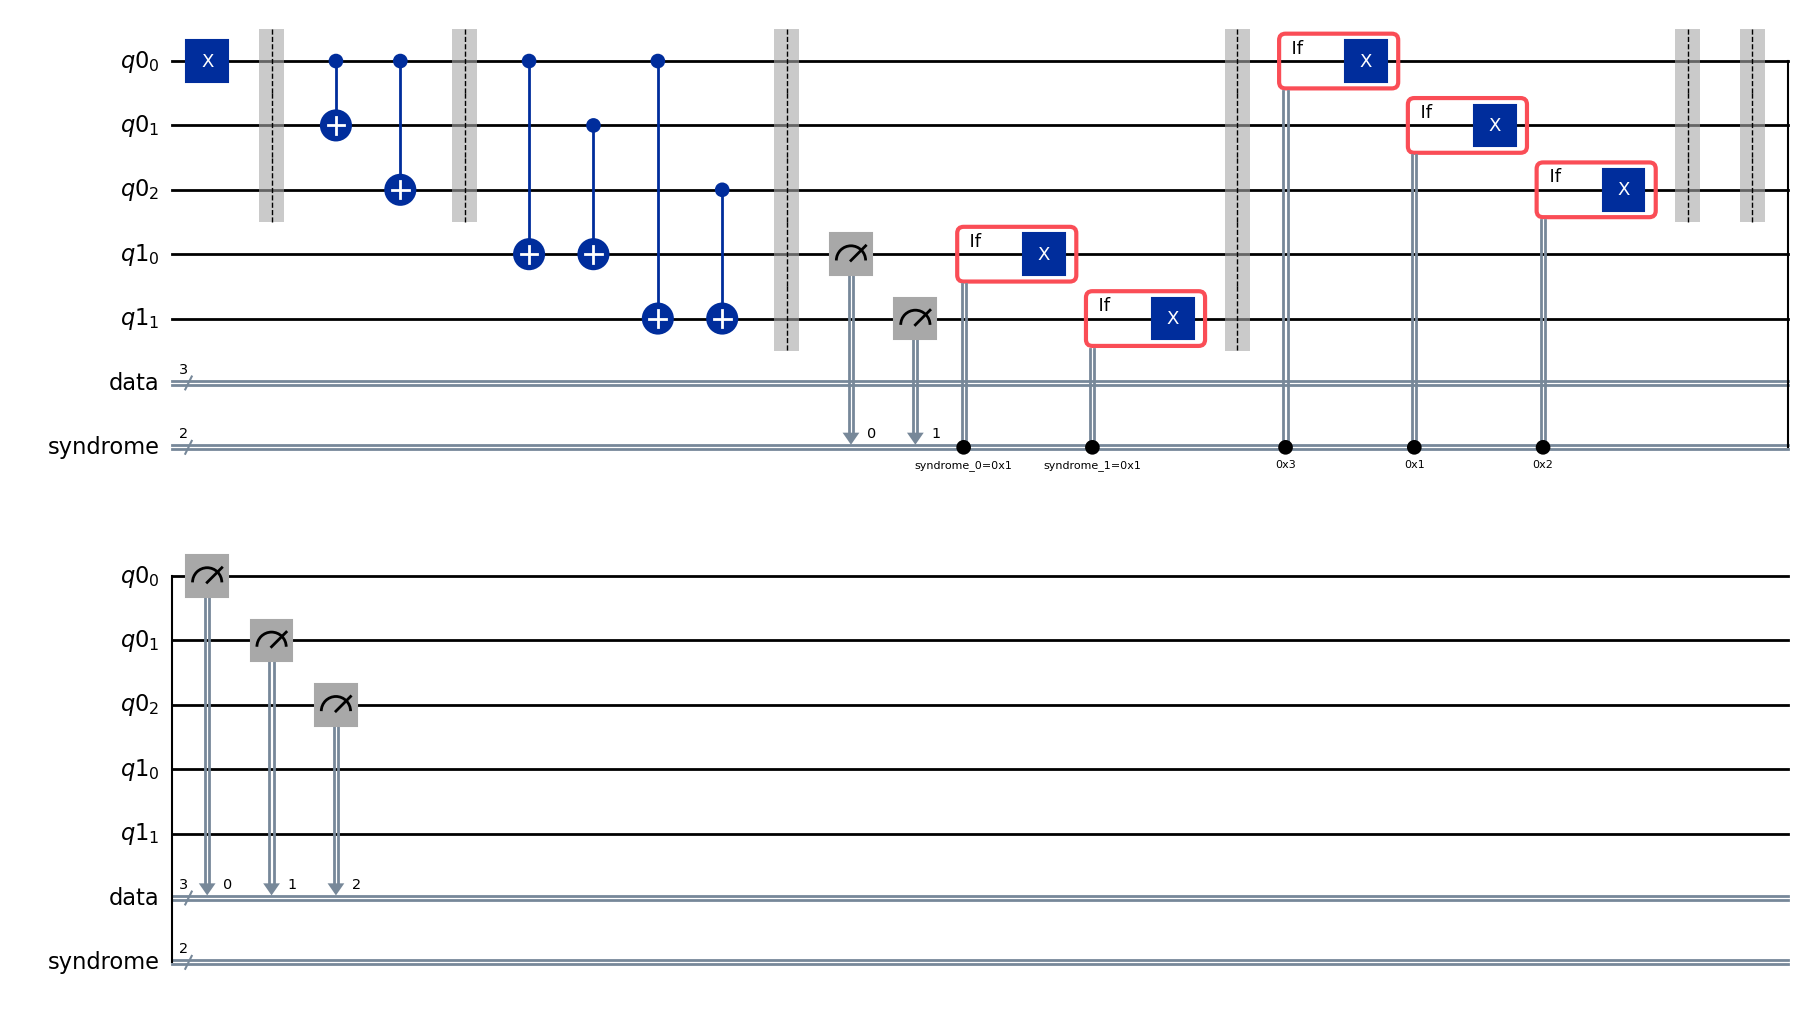

In [3]:
def build_error_correction_sequence(apply_correction: bool) -> QuantumCircuit: 
    circuit = build_qc()
    circuit = initialize_qubits(circuit)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_syndrome)
    
    if apply_correction: 
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)
        
    circuit = apply_final_readout(circuit, qreg_data, creg_data)
    return circuit

circuit = build_error_correction_sequence(apply_correction=True)
circuit.draw(output="mpl", style="iqp")

### Optimization for quantum execution

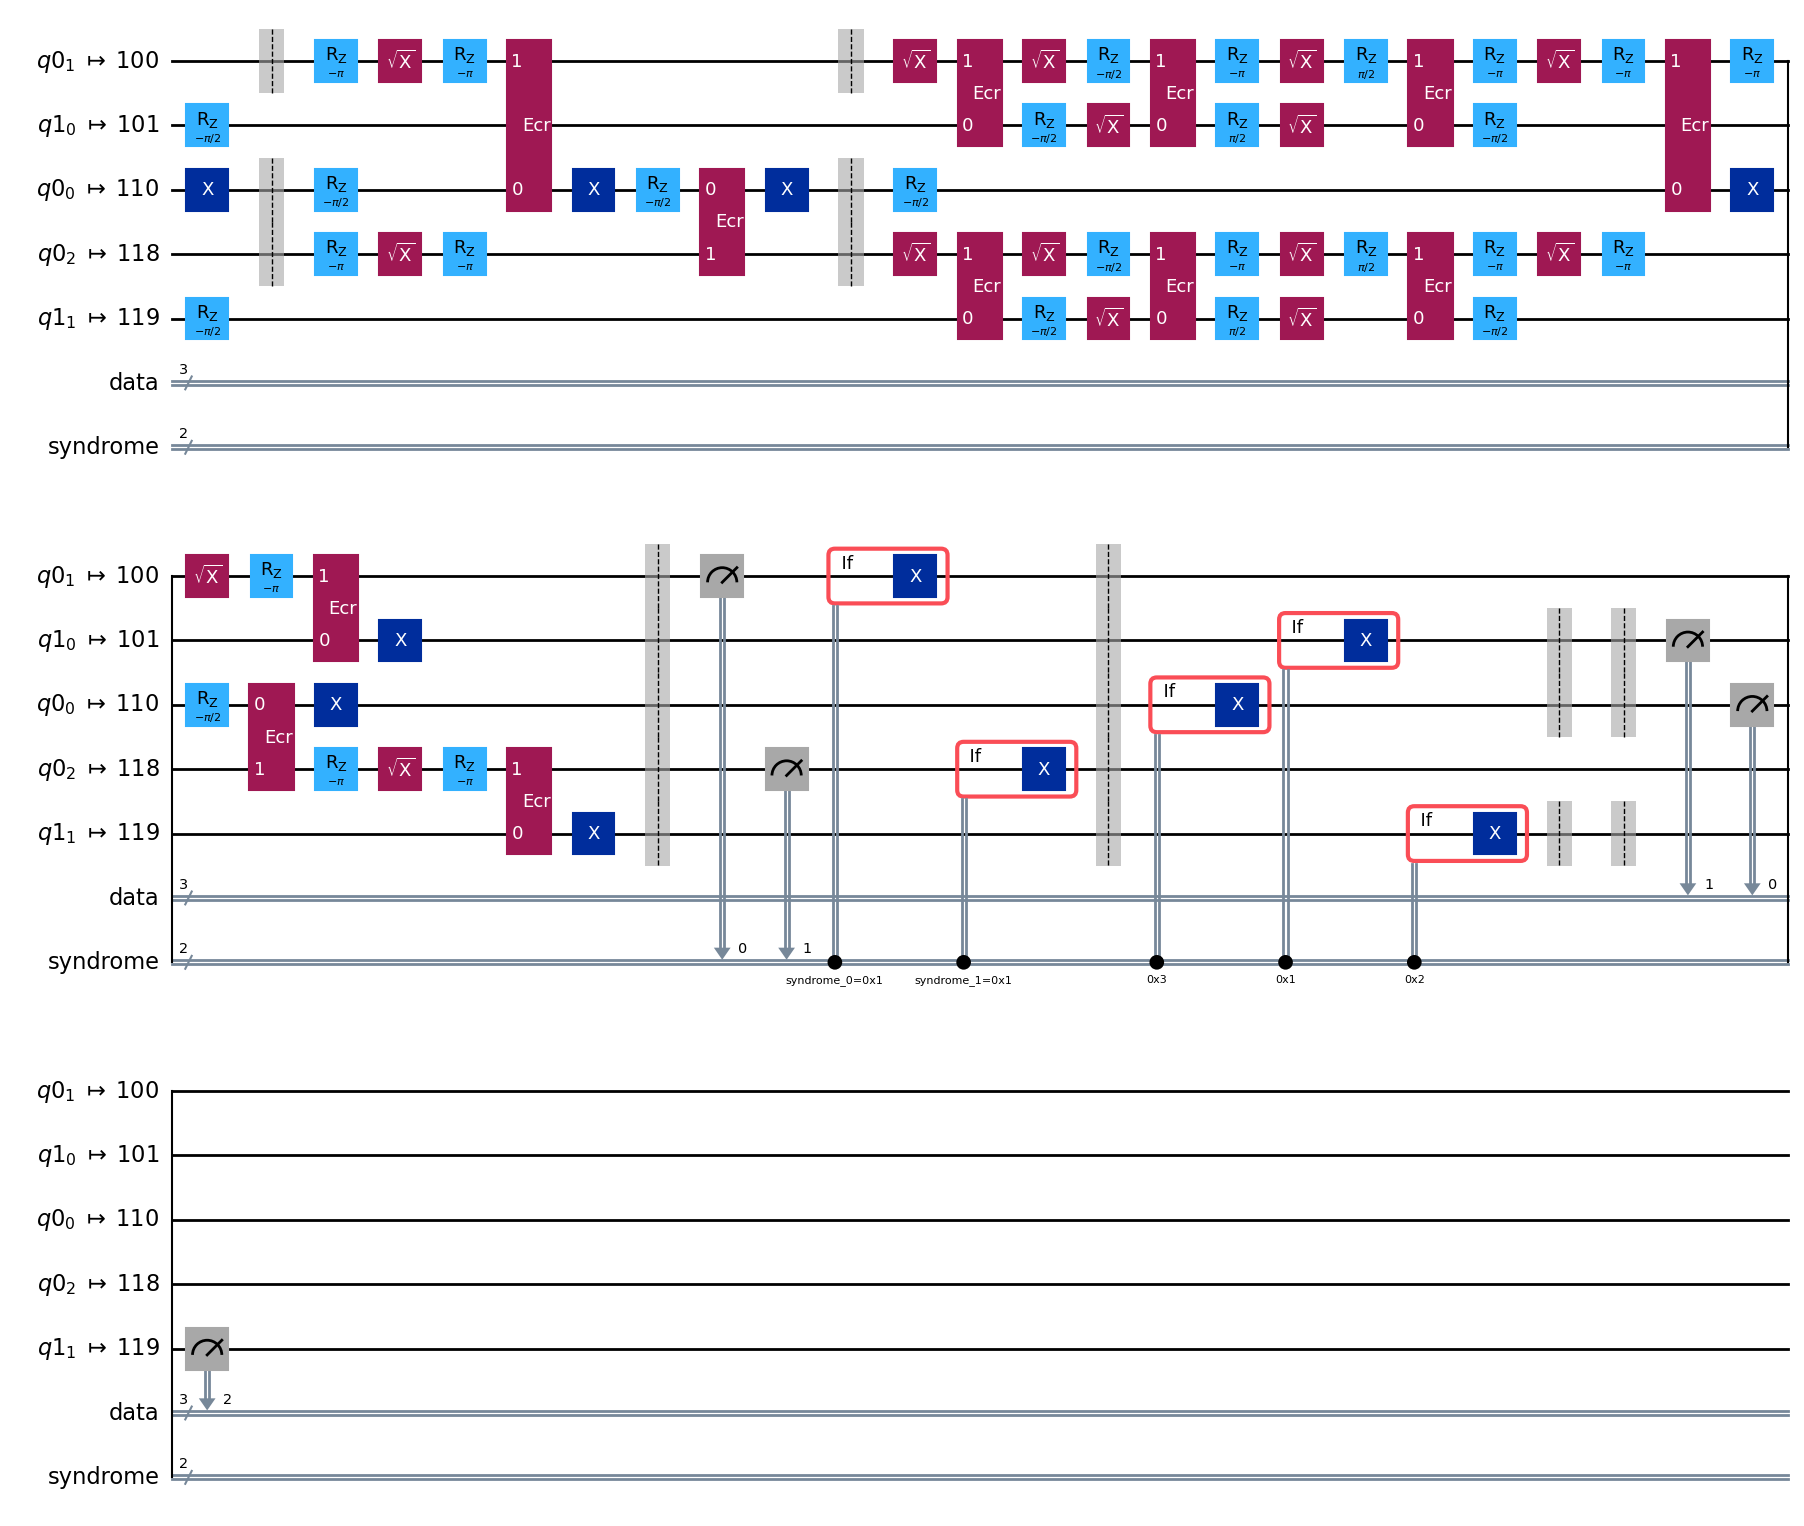

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

isa_circuit.draw("mpl", style="iqp", idle_wires=False)

In [5]:
no_correction_circuit = build_error_correction_sequence(apply_correction=False)
isa_no_correction_circuit = pm.run(no_correction_circuit)

### Quantum execution

In [6]:
sampler_no_correction = Sampler(backend)
job_no_correction = sampler_no_correction.run([isa_no_correction_circuit], shots=1000)
result_no_correction = job_no_correction.result()[0]

In [7]:
sampler_with_correction = Sampler(backend)
job_with_correction = sampler_with_correction.run([isa_circuit], shots=1000)
result_with_correction = job_with_correction.result()[0]

In [8]:
print(f"Data (no correction): \n{result_no_correction.data.data.get_counts()}")
print(f"Syndrome (no correction): \n{result_no_correction.data.syndrome.get_counts()}")

Data (no correction): 
{'001': 15, '101': 283, '111': 642, '110': 12, '100': 11, '011': 22, '010': 13, '000': 2}
Syndrome (no correction): 
{'01': 285, '00': 686, '11': 13, '10': 16}


In [9]:
print(f"Data (corrected): \n{result_with_correction.data.data.get_counts()}")
print(f"Syndrome (corrected): \n{result_with_correction.data.syndrome.get_counts()}")

Data (corrected): 
{'111': 840, '000': 11, '110': 22, '011': 86, '101': 33, '010': 2, '100': 3, '001': 3}
Syndrome (corrected): 
{'01': 25, '00': 929, '10': 35, '11': 11}


### Post-processing

In [16]:
def decode_result(data_counts, syndrome_counts):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('00', 0)
    print(f"Bit-flip errors were detected/corrected on {error_correction_events}/{shots} trials.")
    print(f"A final parity error was detected on {failed_trials}/{shots} trials.")

In [17]:
data_result = result_no_correction.data.data.get_counts()
marginalized_syndrome_result = result_no_correction.data.syndrome.get_counts()

print(f"Completed bit code experiment data measurement counts (no correction): {data_result}")
print(f"Completed bit code experiment syndrome measurement counts (no correction): {marginalized_syndrome_result}")
decode_result(data_result, marginalized_syndrome_result)

Completed bit code experiment data measurement counts (no correction): {'001': 15, '101': 283, '111': 642, '110': 12, '100': 11, '011': 22, '010': 13, '000': 2}
Completed bit code experiment syndrome measurement counts (no correction): {'01': 285, '00': 686, '11': 13, '10': 16}
Bit-flip errors were detected/corrected on 314/1000 trials.
A final parity error was detected on 356/1000 trials.


In [18]:
corrected_data_result = result_with_correction.data.data.get_counts()
corrected_marginalized_syndrome_result = result_with_correction.data.syndrome.get_counts()

print(f"Completed bit code experiment data measurement counts (corrected): {corrected_data_result}")
print(f"Completed bit code experiment syndrome measurement counts (corrected): {corrected_marginalized_syndrome_result}")
decode_result(corrected_data_result, corrected_marginalized_syndrome_result)

Completed bit code experiment data measurement counts (corrected): {'111': 840, '000': 11, '110': 22, '011': 86, '101': 33, '010': 2, '100': 3, '001': 3}
Completed bit code experiment syndrome measurement counts (corrected): {'01': 25, '00': 929, '10': 35, '11': 11}
Bit-flip errors were detected/corrected on 71/1000 trials.
A final parity error was detected on 149/1000 trials.
